# Install and import kaggle library
Kaggle library is useful to connect to kaggle website and download datasets to local computer. 

In [1]:
!pip install kaggle

In [2]:
import kaggle

# Download ecommerce datasets from kaggle website using kaggle library
## Follow below steps before using kaggle library
    1. Login to kaggle, go to settings and create new token
    2. This will download kaggle.json
    3. Now place this file to <home directory>/.kaggle folder

In [3]:
kaggle.api.authenticate()

In [4]:
kaggle.api.dataset_download_files('devarajv88/target-dataset', path='Ecommerce Dataset', unzip=True, quiet=False)

Dataset URL: https://www.kaggle.com/datasets/devarajv88/target-dataset


100%|██████████████████████████████████████████████████████████████████████████████| 36.2M/36.2M [00:00<00:00, 628MB/s]

## Check the downloaded files using os library

In [5]:
import os

In [6]:
os.listdir('Ecommerce Dataset/')

['customers.csv',
 'geolocation.csv',
 'orders.csv',
 'order_items.csv',
 'payments.csv',
 'products.csv',
 'sellers.csv']

# Load the environment variables (database details) using dotenv and os libraries
Create a **.env** file and add the environment variables to this file for security purpose.<br>
**Examples:**<br>
mssql=mssql://<code>dbname</code>/<code>schemaname</code>?driver=ODBC+DRIVER+17+FOR+SQL+SERVER <br>
userid=<code>userid</code><br>
password=<code>password</code>

**Note:** Do not enclose variable information into single quotes.

In [7]:
import dotenv

In [8]:
dotenv.load_dotenv()
mssql_db = os.getenv('mssql')

# Create database connection using sqlalchemy

In [9]:
from sqlalchemy import create_engine, text
engine = create_engine(mssql_db)
conn = engine.connect()

# Create functions 
* Create function to map python data type to SQL Server data type
* Create function to generate CREATE TABLE statement
* Create function to calculate elapsed time of data loading process

In [10]:
# Map python data type to sql data type
def get_sql_dtype(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOL'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'VARCHAR'

# Generate create table statement
def create_table_stmt(df, table_name):
    col_list = []
    for col in df.columns:
        col_dtype = get_sql_dtype(df[col].dtype)

        # fetch max lengh of the column data if the column is of object type 
        # requied to provide data type length in sql server
        if df[col].dtype == 'object':
            col_len = int(df[col].str.len().max()) + 10
            col_list.append(f'{col} {col_dtype}({col_len})')
        else:
            col_list.append(f'{col} {col_dtype}')

    # alternate method using list comprehensions
    # col_list = [f'{col} {get_sql_dtype(df[col].dtype)}' if df[col].dtype != 'object' \
    #             else f'{col} {get_sql_dtype(df[col].dtype)}({int(df[col].str.len().max()) + 10})' for col in df.columns]
    
    query = f'create table {table_name} ({', '.join(col_list)})'
    return query

# Calculate elased time in hours, minutes, seconds
def calculate_elapsed_time(start_time, end_time):
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time.total_seconds(), 60)
    hours, minutes = divmod(minutes, 60)
    return (round(hours), round(minutes), round(seconds))

# Load datasets to SQL Server using pandas and sqlalchemy libraries
**Approach for data load process:**
1. Loop each file present in dataset folder
2. Read CSV file into pandas dataframe
3. Clean dataframe columns
4. Generate create table statement and execute to create respective table into SQL Server
5. Load dataframe data to SQL Server
6. Calculate total time taken in loading process

In [11]:
import pandas as pd
import datetime

In [12]:
# fetch the current time before starting the load 
start_time = datetime.datetime.now()

# loop each file present in dataset folder
for file in os.listdir('Ecommerce Dataset/'):
    full_file_path = os.path.join('Ecommerce Dataset',file)
    # print(full_file_path)

    # read CSV file into dataframe
    df = pd.read_csv(full_file_path)
    
    # clean dataframe columns
    df.columns = [col.replace(' ','_').replace('-','_').replace('.','_') for col in df.columns]

    # generate create table statement for each dataframe
    table_name = file.split('.')[0]
    create_table_query = create_table_stmt(df, table_name)
    # print(create_table_query)

    # execute table statement
    conn.execute(text(create_table_query))
    conn.commit()

    # load data to sql server
    df.to_sql(table_name, con=conn, index=False, if_exists='append')
    print(f'Successfully loaded {full_file_path} to SQL Server')

# fetch the current time after completing the load
end_time = datetime.datetime.now()

# calculate elapsed time and print total time taken to complete the load process
print(f'Total Elapsed Time: {(end_time - start_time).total_seconds()}')
hh, mi, ss = calculate_elapsed_time(start_time, end_time)
print(f'Total time taken: {hh} hrs, {mi} minutes, {ss} seconds')

Successfully loaded Ecommerce Dataset\customers.csv to SQL Server
Successfully loaded Ecommerce Dataset\geolocation.csv to SQL Server
Successfully loaded Ecommerce Dataset\orders.csv to SQL Server
Successfully loaded Ecommerce Dataset\order_items.csv to SQL Server
Successfully loaded Ecommerce Dataset\payments.csv to SQL Server
Successfully loaded Ecommerce Dataset\products.csv to SQL Server
Successfully loaded Ecommerce Dataset\sellers.csv to SQL Server
Total Elapsed Time: 133.356493
Total time taken: 0 hrs, 2 minutes, 13 seconds


# Close the database connection

In [13]:
conn.close()

# Enable SQL magic function
**Follow below steps to enable SQL Magic function:**
* Load libraries ipython-sql and prettytable
  <code>!pip install ipython-sql prettytable</code>
  <code>import prettytable</code>
* Enable SQL magic by loading the SQL extension <code>%load_ext sql</code>
* Fetch the database connection details from environment file using dotenv and os libraries
* Establish connection between SQL magic module and SQL Server <code>%sql $mssql_db</code>

## Load libraries ipython-sql and prettytable

In [14]:
!pip install ipython-sql prettytable

In [15]:
import prettytable
prettytable.DEFAULT = 'DEFAULT'

## Enable SQL magic by loading the SQL extension

In [16]:
%load_ext sql

## Fetch the database connection details from environment file using dotenv and os libraries

In [17]:
# Not needed here as information already fetched while loading data to SQL Server 
# import os, dotenv
# dotenv.load_dotenv()
# mssql_db = os.getenv('mssql')

## Establish connection between SQL magic module and SQL Server

In [18]:
%sql $mssql_db

# Execute queries in jupyter notebook using SQL magic
**Note:**<br>
use <code>%sql</code> for single line SQL queries and <code>%%sql</code> for multi line SQL queries <br>
use <code>%%capture --no-display</code> for hiding database details. However, it also hides the SQL errors. So, to see error while development, remove this line of code.

## Ex 1: Fetch data from tables

In [19]:
%%capture --no-display
%sql select top 10 * from customers;

customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC
fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP
5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG
5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR
4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG


## Ex 2: Fetch count from all tables

In [20]:
%%capture --no-display
%sql select count(*) cnt from customers;

cnt
99441


In [21]:
%%capture --no-display
%sql select count(*) cnt from geolocation;

cnt
1000163


## Ex 3: Store the query output into python variables

In [22]:
%%capture --no-display
orders_count = %sql select count(*) cnt from orders;

In [23]:
orders_count

cnt
99441


In [24]:
%%capture --no-display
order_items_count = %sql select count(*) cnt from order_items;
payments_count = %sql select count(*) cnt from payments;
products_count = %sql select count(*) cnt from products;
sellers_count = %sql select count(*) cnt from sellers;

In [25]:
order_items_count

cnt
112650


In [26]:
payments_count

cnt
103886


In [27]:
products_count

cnt
32951


In [28]:
sellers_count

cnt
3095


## Ex 4: Convert the query output to pandas dataframe

In [29]:
import pandas as pd
df = pd.DataFrame(sellers_count)
df

,cnt
0,3095


## Q1. Count the number of orders placed each year and display in descending order.
**Approach:**
* Calculate aggregated order count for each year from table <code>ORDERS</code>.
* Sort the output in descending order.
* Result shows that year 2018 has the maximum orders.

In [30]:
%%capture --no-display
%%sql 
select year(order_purchase_timestamp) year, count(*) count
from orders
group by year(order_purchase_timestamp)
order by 2 desc;

year,count
2018,54011
2017,45101
2016,329


## Q2. Count the number of orders for each year, month (display months in rows and years in columns)
I have used 2 methods to achieve the result. 
* Using case when clause
* Using pivot function

**Approach:**
* Fetch year, month number, month name and order id from table <code>ORDERS</code>.
* Aggregate number of orders for each month. Transpose each year to separate column using <code>CASE WHEN</code> clause.
* Alternatively, use <code>PIVOT</code> function to aggregate data.

### Using case when clause

In [32]:
%%capture --no-display
%%sql 
with year_month_orders as (
select year(order_purchase_timestamp) order_year, month(order_purchase_timestamp) month_number, 
       format(cast(order_purchase_timestamp as date),'MMMM') order_month, order_id
from orders)
select month_number, order_month,
sum((case when order_year = 2016 then 1 else 0 end)) year_2016,
sum((case when order_year = 2017 then 1 else 0 end)) year_2017,
sum((case when order_year = 2018 then 1 else 0 end)) year_2018
from year_month_orders
group by month_number, order_month
order by month_number;

month_number,order_month,year_2016,year_2017,year_2018
1,January,0,800,7269
2,February,0,1780,6728
3,March,0,2682,7211
4,April,0,2404,6939
5,May,0,3700,6873
6,June,0,3245,6167
7,July,0,4026,6292
8,August,0,4331,6512
9,September,4,4285,16
10,October,324,4631,4


### Using pivot function

In [33]:
%%capture --no-display
%%sql 
with year_month_orders as (
select year(order_purchase_timestamp) order_year, month(order_purchase_timestamp) month_number, 
       format(cast(order_purchase_timestamp as date),'MMMM') order_month, order_id
from orders
) 
select month_number, order_month, 
       [2016] as year_2016, [2017] as year_2017, [2018] as year_2018 
from year_month_orders
pivot (count(order_id) for order_year in ([2016], [2017], [2018])) as t2
order by month_number;

month_number,order_month,year_2016,year_2017,year_2018
1,January,0,800,7269
2,February,0,1780,6728
3,March,0,2682,7211
4,April,0,2404,6939
5,May,0,3700,6873
6,June,0,3245,6167
7,July,0,4026,6292
8,August,0,4331,6512
9,September,4,4285,16
10,October,324,4631,4


## Q3. From the previous query, compare 2017 and 2018 sales using line chart.
**Follow below steps:**
* Store the query output to variable.
* Convert it to pandas dataframe.
* Plot a line chart using visualization libraries.

**Note:** <br>
To store the query output to a variable, use single line sql magic <code>%sql</code>. Multi-line sql magic will not work.

### Store the query output to a variable

In [34]:
%%capture --no-display
data = %sql \
with year_month_orders as ( \
select year(order_purchase_timestamp) order_year, month(order_purchase_timestamp) month_number, \
       format(cast(order_purchase_timestamp as date),'MMMM') order_month, order_id \
from orders) \
select month_number, order_month, \
       [2016] as year_2016, [2017] as year_2017, [2018] as year_2018 \
from year_month_orders \
pivot (count(order_id) for order_year in ([2016], [2017], [2018])) as t2 \
order by month_number; 

### Convert query output to pandas dataframe

In [35]:
df = pd.DataFrame(data)
df

,month_number,order_month,year_2016,year_2017,year_2018
0,1,January,0,800,7269
1,2,February,0,1780,6728
2,3,March,0,2682,7211
3,4,April,0,2404,6939
4,5,May,0,3700,6873
5,6,June,0,3245,6167
6,7,July,0,4026,6292
7,8,August,0,4331,6512
8,9,September,4,4285,16
9,10,October,324,4631,4


### Import visualization libraries matplotlib and seaborn

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

### Display data using barchart
**Approach:**
* Provide size of chart using figsize.
* Plot chart for year 2017 and 2018 using seaborn <code>lineplot</code> function.
* Provide label for x axis, y axis and title for chart.
* Rotate x axis ticks if required.
* Use annotate to provide label to each line.

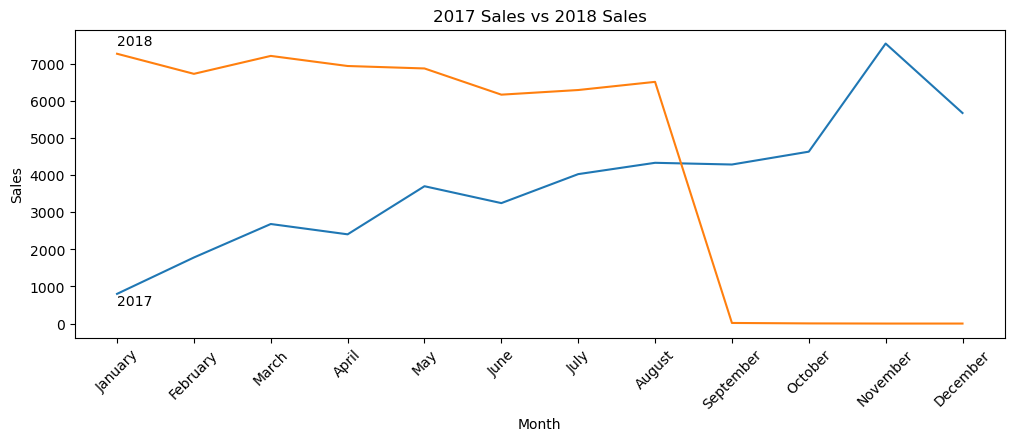

In [37]:
# Provide size of chart using figsize
plt.figure(figsize=(12,4))

# Plot chart for year 2017 and 2018
sns.lineplot(data=df, x='order_month', y='year_2017')
sns.lineplot(data=df, x='order_month', y='year_2018')

# Provide label for x axis and y axis
plt.xlabel('Month')
plt.ylabel('Sales')

# Provide title for chart
plt.title('2017 Sales vs 2018 Sales')

# Rotate x axis ticks to 45 degree
plt.xticks(rotation=45)

# Use annotate to provide label to each line
# (0,500) is x and y value where we want to print the text 
plt.annotate('2017',(0,500))
plt.annotate('2018',(0,7500))
plt.show()

## Q4. Count the numbers of orders for each order-status along with the percentage.
**Approach:**
* Calculate aggregated order count grouped by order status from table <code>ORDERS</code>.
* Sum all order counts to calculate total order count.
* Calculate order percentage using formula <code>100 * order_status_count / total_order_count</code>.

In [38]:
%%capture --no-display
%%sql 
with agg_orders as (
select order_status, count(*)  order_status_count
from orders
group by order_status)
select order_status, order_status_count, 
sum(order_status_count) over() total_order_count,
round(cast(100.0 * order_status_count / sum(order_status_count) over() as float), 2) order_percentage
from agg_orders
order by order_status_count desc;

order_status,order_status_count,total_order_count,order_percentage
delivered,96478,99441,97.02
shipped,1107,99441,1.11
canceled,625,99441,0.63
unavailable,609,99441,0.61
invoiced,314,99441,0.32
processing,301,99441,0.3
created,5,99441,0.01
approved,2,99441,0.0


## Q5. Find top 10 highest sales generating products
**Approach:**
* To calculate product wise sales, join tables <code>PRODUCTS</code>, <code>PAYMENTS</code>, <code>ORDER_ITEMS</code>.
* Calculate aggregate payemnt_value for each product id.

In [39]:
%%capture --no-display
%%sql 
select top 10 p.product_id, round(sum(pt.payment_value), 2) total_sales
from products p, payments pt, order_items o
where p.product_id = o.product_id
and pt.order_id = o.order_id
group by p.product_id
order by total_sales desc;

product_id,total_sales
5769ef0a239114ac3a854af00df129e4,109312.64
bb50f2e236e5eea0100680137654686c,81887.42
422879e10f46682990de24d770e7f83d,79512.22
d1c427060a0f73f6b889a5c7c61f2ac4,70557.9
6cdd53843498f92890544667809f1595,64825.67
d5991653e037ccb7af6ed7d94246b249,64143.26
aca2eb7d00ea1a7b8ebd4e68314663af,63788.12
a62e25e09e05e6faf31d90c6ec1aa3d1,63167.37
99a4788cb24856965c36a24e339b6058,63161.4
3dd2a17168ec895c781a9191c1e95ad7,58962.14


## Q6. Find the average number of products per order, grouped by customer city.
**Approach:**
* Calculate product count for each order and customer from table <code>ORDER_ITEMS</code>. order_id is repeating in table <code>ORDER_ITEMS</code>.
* Calculate average of product count per order grouped by customer city.
* Sort the output in descending order for average value and fetch top 10 cities.

In [40]:
%%capture --no-display
%%sql
with produt_count_per_order as (
select o.order_id, o.customer_id, count(oi.order_id) product_count
from orders o, order_items oi
where o.order_id = oi.order_id
group by o.order_id, o.customer_id)
select top 10 c.customer_city, avg(co.product_count) average_product_count
from produt_count_per_order co, customers c
where co.customer_id = c.customer_id
group by c.customer_city
order by average_product_count desc;

customer_city,average_product_count
padre carvalho,7
celso ramos,6
datas,6
candido godoi,6
matias olimpio,5
morro de sao paulo,4
curralinho,4
teixeira soares,4
cidelandia,4
picarra,4


## Q7. From the previous query, display top 10 cities with highest average using bar chart.

### Store the query output to a variable

In [41]:
%%capture --no-display
data = %sql with produt_count_per_order as ( \
select o.order_id, o.customer_id, count(oi.order_id) product_count \
from orders o, order_items oi \
where o.order_id = oi.order_id \
group by o.order_id, o.customer_id) \
select top 10 c.customer_city, avg(co.product_count) average_product_count \
from produt_count_per_order co, customers c \
where co.customer_id = c.customer_id \
group by c.customer_city \
order by average_product_count desc;

### Convert query output to pandas dataframe

In [42]:
df = pd.DataFrame(data)
df

,customer_city,average_product_count
0,padre carvalho,7
1,celso ramos,6
2,datas,6
3,candido godoi,6
4,matias olimpio,5
5,morro de sao paulo,4
6,curralinho,4
7,teixeira soares,4
8,cidelandia,4
9,picarra,4


### Display data using bar chart
**Approach:**
* Provide size of chart using figsize.
* Plot bar chart using seaborn <code>barplot</code> function.
* Provide label for x axis, y axis and title for chart.
* Rotate x axis ticks if required.

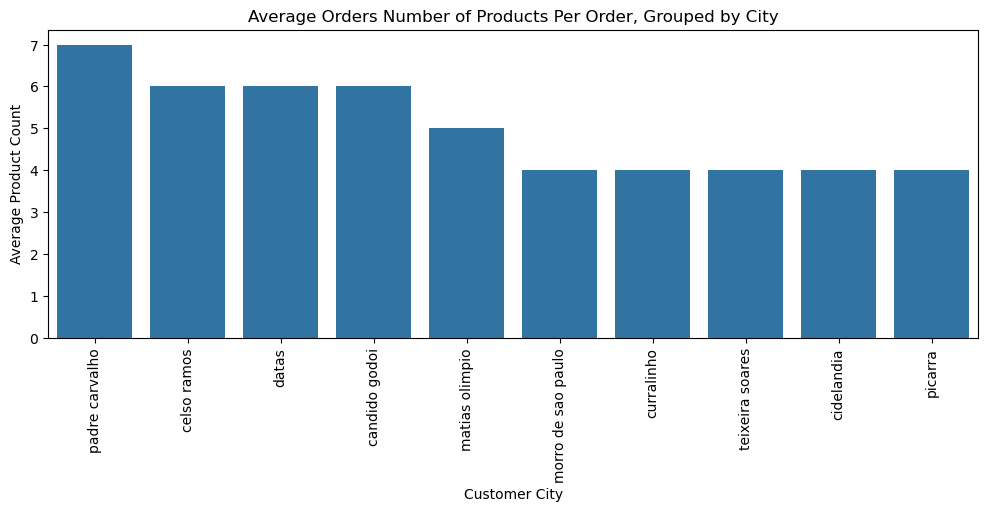

In [43]:
# Provide size of chart using figsize
plt.figure(figsize=(12,4))

# Plot bar chart
sns.barplot(data=df, x='customer_city', y='average_product_count')

# Provide label for x axis, y axis and title 
plt.title('Average Orders Number of Products Per Order, Grouped by City')
plt.xlabel('Customer City')
plt.ylabel('Average Product Count')

# Rotate x axis ticks to 90 degree
plt.xticks(rotation = 90)
plt.show()

## Q8. Find the total sales per product category and display in descending order.
**Approach:**
* To calculate product category wise sales, join tables <code>PRODUCTS</code>, <code>PAYMENTS</code>, <code>ORDER_ITEMS</code>.
* Calculate aggregate payemnt_value for each product category.
* Sort data in descending order for sales.

In [44]:
%%capture --no-display
%%sql 
select upper(p.product_category) product_category, round(sum(pt.payment_value), 2) total_sales
from products p, payments pt, order_items o
where p.product_id = o.product_id
and pt.order_id = o.order_id
group by p.product_category
order by total_sales desc;

product_category,total_sales
BED TABLE BATH,1712553.67
HEALTH BEAUTY,1657373.12
COMPUTER ACCESSORIES,1585330.45
FURNITURE DECORATION,1430176.39
WATCHES PRESENT,1429216.68
SPORT LEISURE,1392127.56
HOUSEWARES,1094758.13
AUTOMOTIVE,852294.33
GARDEN TOOLS,838280.75
COOL STUFF,779698.0


## Q9. Find the top 10 highest selling product category and display using bar chart.
**Approach:**
* From previous query output, fetch top 10 records into python variable.
* Convert the query output to pandas dataframe.
* Plot bar chart using seaborn <code>barplot</code> function

### Store the query output to a variable

In [45]:
%%capture --no-display
data = %sql \
select top 10 upper(p.product_category) product_category, round(sum(pt.payment_value), 2) total_sales \
from products p, payments pt, order_items o \
where p.product_id = o.product_id \
and pt.order_id = o.order_id \
group by p.product_category \
order by 2 desc;

### Convert query output to dataframe and plot barchart

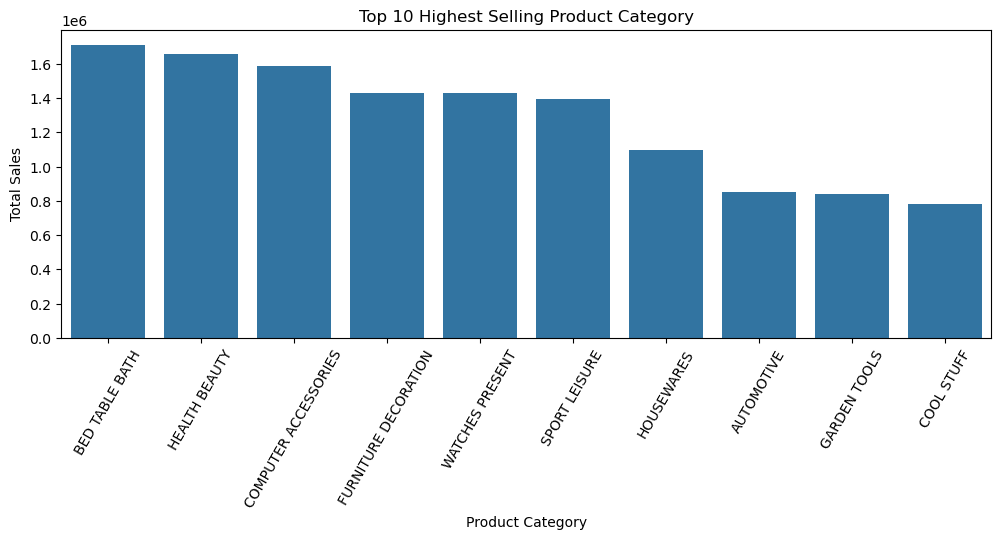

In [46]:
# create dataframe
df = pd.DataFrame(data)

# Provide size of chart using figsize
plt.figure(figsize=(12,4))

# Plot bar chart
sns.barplot(data=df, x='product_category', y='total_sales')

# Provide label for x axis, y axis and title
plt.title('Top 10 Highest Selling Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales')

# Rotate x axis ticks to 60 degree
plt.xticks(rotation = 60)
plt.show()

## Q10. Find highest selling month for each product category.
**Approach:**
* Join tables <code>PRODUCTS</code>, <code>PAYMENTS</code>, <code>ORDER_ITEMS</code> and <code>ORDERS</code>.
* Calculate aggregated sales grouped by year, month and product category.
* Calculate row number for each record partitioned by product category and ordered by sales in descending order.
* Fetch the first record for each product category, year and month (where row number = 1).
* Sort data by year, month and product category.

In [47]:
%%capture --no-display
%%sql 
with agg_sales as (
select year(o.order_purchase_timestamp) order_year, format(cast(o.order_purchase_timestamp as date),'MMMM') order_month, 
upper(p.product_category) product_category, round(sum(pt.payment_value), 2) total_sales,
row_number() over(partition by p.product_category order by sum(pt.payment_value) desc) rn
from products p, payments pt, order_items oi, orders o
where p.product_id = oi.product_id
and pt.order_id = oi.order_id
and oi.order_id = o.order_id
group by year(o.order_purchase_timestamp), format(cast(o.order_purchase_timestamp as date),'MMMM'), p.product_category)
select product_category, order_year, order_month, total_sales
from agg_sales 
where rn = 1
order by order_year, order_month, product_category;

product_category,order_year,order_month,total_sales
MARKET PLACE,2016,October,4955.87
ELECTROSTILE,2017,April,24237.33
AUTOMOTIVE,2017,August,79818.53
FASHION CALCADOS,2017,August,2746.13
INSURANCE AND SERVICES,2017,January,209.06
CDS MUSIC DVDS,2017,July,421.6
BLU RAY DVDS,2017,March,2028.79
HOUSE COMFORT 2,2017,March,390.89
ART,2017,May,7365.95
FURNITURE,2017,May,6065.93


## Q11. Find highest selling product category for each year and month.
**Approach:**
* Join tables <code>PRODUCTS</code>, <code>PAYMENTS</code>, <code>ORDER_ITEMS</code> and <code>ORDERS</code>.
* Calculate aggregated sales grouped by year, month and product category.
* Calculate row number for each record partitioned by year and month and ordered by sales in descending order.
* Fetch the first record for each year, month and product category(where row number = 1).
* Sort data by year and month.

In [48]:
%%capture --no-display
%%sql 
with agg_sales as (
select year(o.order_purchase_timestamp) order_year, month(o.order_purchase_timestamp) order_month_number, 
format(cast(o.order_purchase_timestamp as date),'MMMM') order_month, 
upper(p.product_category) product_category, round(sum(pt.payment_value), 2) total_sales,
row_number() over(partition by year(o.order_purchase_timestamp), month(o.order_purchase_timestamp) order by sum(pt.payment_value) desc) rn
from products p, payments pt, order_items oi, orders o
where p.product_id = oi.product_id
and pt.order_id = oi.order_id
and oi.order_id = o.order_id
group by year(o.order_purchase_timestamp), format(cast(o.order_purchase_timestamp as date),'MMMM'), 
month(o.order_purchase_timestamp), p.product_category)
select order_year, order_month, product_category, total_sales
from agg_sales 
where rn = 1
order by order_year, order_month_number;

order_year,order_month,product_category,total_sales
2016,September,FURNITURE DECORATION,272.46
2016,October,FURNITURE DECORATION,10852.54
2016,December,FASHION BAGS AND ACCESSORIES,19.62
2017,January,FURNITURE DECORATION,27882.8
2017,February,FURNITURE DECORATION,35889.13
2017,March,FURNITURE DECORATION,41781.58
2017,April,FURNITURE DECORATION,40763.09
2017,May,COMPUTER ACCESSORIES,83669.28
2017,June,COMPUTER ACCESSORIES,58864.94
2017,July,BED TABLE BATH,101051.68


## Q12. Find highest selling product category for each year.
**Approach:**
* Join tables <code>PRODUCTS</code>, <code>PAYMENTS</code>, <code>ORDER_ITEMS</code> and <code>ORDERS</code>.
* Calculate aggregated sales grouped by year and product category.
* Calculate row number for each record partitioned by year and ordered by sales in descending order.
* Fetch the first record for each year and product category(where row number = 1).
* Sort data by year.

In [49]:
%%capture --no-display
%%sql 
with agg_sales as (
select year(o.order_purchase_timestamp) order_year, upper(p.product_category) product_category, 
round(sum(pt.payment_value), 2) total_sales,
row_number() over(partition by year(o.order_purchase_timestamp) order by sum(pt.payment_value) desc) rn
from products p, payments pt, order_items oi, orders o
where p.product_id = oi.product_id
and pt.order_id = oi.order_id
and oi.order_id = o.order_id
group by year(o.order_purchase_timestamp), p.product_category)
select order_year, product_category, total_sales
from agg_sales 
where rn = 1
order by order_year;

order_year,product_category,total_sales
2016,FURNITURE DECORATION,11125.0
2017,BED TABLE BATH,797314.22
2018,HEALTH BEAUTY,1033604.09


## Q13. Calculate the total sales generated by each seller, rank them by sales in descending order and display top 10 records.
**Approach:**
* Join tables <code>ORDER_ITEMS</code> and <code>PAYMENTS</code>.
* Calculate aggregate payment_value for each seller.
* Calculate rank for each record ordered by sales in descending order.
* Fetch top 10 records.

In [50]:
%%capture --no-display
%%sql
select top 10 o.seller_id, round(sum(p.payment_value), 2) total_sales,
dense_rank() over(order by sum(p.payment_value) desc) seller_rank
from order_items o, payments p
where o.order_id = p.order_id
group by o.seller_id;

seller_id,total_sales,seller_rank
7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
4a3ca9315b744ce9f8e9374361493884,301245.27,3
1f50f920176fa81dab994f9023523100,290253.42,4
53243585a1d6dc2643021fd1853d8905,284903.08,5
da8622b14eb17ae2831f4ac5b9dab84a,272219.32,6
4869f7a5dfa277a7dca6462dcf3b52b2,264166.12,7
955fee9216a65b617aa5c0531780ce60,236322.3,8
fa1c13f2614d7b5c4749cbc52fecda94,206513.23,9
7e93a43ef30c4f03f38b393420bc753a,185134.21,10


## Q14. Calculate the cumulative sales per month for each year.
**Approach:**
* To calculate cumulative sales or running total, join tables <code>ORDER_ITEMS</code> and <code>PAYMENTS</code>.
* Calculate Aggregated payment_value grouped by year and month.
* Calculate cumulative sales by partitioning data by year and order by month. This will generate running totals. 

In [51]:
%%capture --no-display
data = %sql \
with agg_sales as ( \
select year(o.order_purchase_timestamp) order_year, month(o.order_purchase_timestamp) order_month, \
round(sum(p.payment_value), 2) monthly_sales \
from orders o, payments p \
where o.order_id = p.order_id \
group by year(o.order_purchase_timestamp), month(o.order_purchase_timestamp)) \
select order_year, order_month, monthly_sales, \
sum(monthly_sales) over(partition by order_year order by order_month) cumm_sales \
from agg_sales \
order by order_year, order_month; \

df = pd.DataFrame(data)
df

,order_year,order_month,monthly_sales,cumm_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,138488.04
4,2017,2,291908.01,430396.05
5,2017,3,449863.60,880259.65
6,2017,4,417788.03,1298047.68
7,2017,5,592918.82,1890966.50
8,2017,6,511276.38,2402242.88
9,2017,7,592382.92,2994625.80


## Q15. From previous query output, plot cumulative sales and monthly sales for each year using line chart.
**Approach:**
* Plot line chart using seaborn <code>lineplot</code> function.
* Use <code>plt.xticks</code> function to manually change the x axis ticks and give user-defined labels.

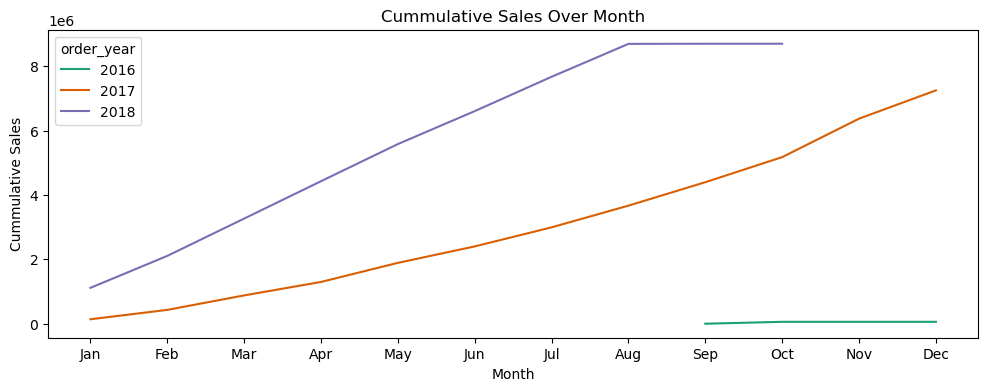

In [52]:
# Provide size of chart using figsize
plt.figure(figsize=(12,4))

# Plot line chart
sns.lineplot(data=df, x='order_month', y='cumm_sales', hue='order_year', palette='Dark2')

# Provide label for x axis, y axis and title
plt.xlabel('Month')
plt.ylabel('Cummulative Sales')
plt.title('Cummulative Sales Over Month')

# Provide label to x axis ticks
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12], labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

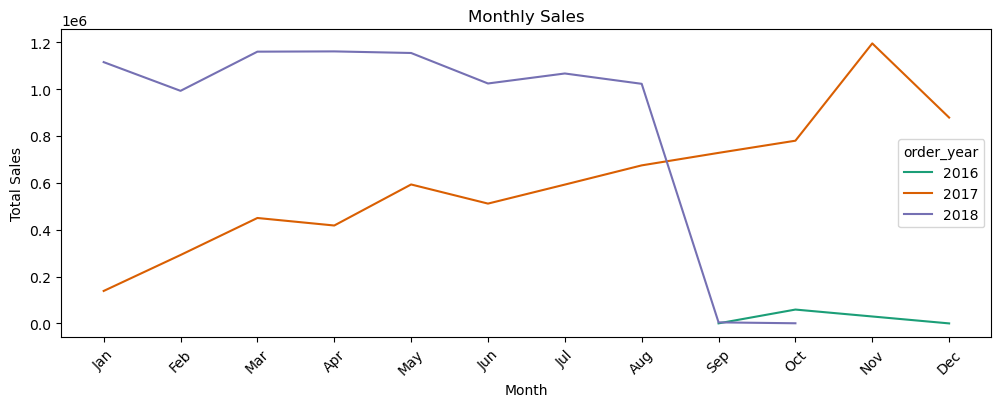

In [53]:
# Provide size of chart using figsize
plt.figure(figsize=(12,4))

# Plot line chart
sns.lineplot(data=df, x='order_month', y='monthly_sales', hue='order_year', palette='Dark2')

# Provide label for x axis, y axis and title
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales')

# Provide label to x axis ticks
plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12], labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)
plt.show()

## Q16. Calculate the year-over-year growth rate of total sales.
**Approach:**
* Join tables <code>ORDERS</code> and <code>PAYMENTS</code> using order_id column.
* Calculate aggregated sales grouped by year.
* Get the previous year sales in the current record using <code>LAG</code> analytical function.
* Calculate YOY growth by using formula <code>100 * (current_sales - prev_sales) / prev_sales</code>.

In [54]:
%%capture --no-display
%%sql
with yearly_sales as ( 
select year(o.order_purchase_timestamp) order_year, round(sum(p.payment_value), 2) current_year_sales 
from orders o, payments p 
where o.order_id = p.order_id 
group by year(o.order_purchase_timestamp)), 
prev_year_sales as ( 
select order_year, current_year_sales, lag(current_year_sales, 1) over(order by order_year) prev_sales 
from yearly_sales) 
select *, (100 * (current_year_sales - prev_sales) / prev_sales) as yoy_percent_growth 
from prev_year_sales
order by order_year; 

order_year,current_year_sales,prev_sales,yoy_percent_growth
2016,59362.34,None,None
2017,7249746.73,59362.34,12112.703761340945
2018,8699763.05,7249746.73,20.00092381158259


## Q17. Find the order percentage which contributed towards 80% of sales (pareto principle 80/20 rule)
**Approach:**
* Join tables <code>ORDERS</code> and <code>PAYMENTS</code> using order_id column. 
* Calculate aggregated sales grouped by order id.
* Calculate sales running total ordered by order sales in descending order.
* Calculate 80 % of sales of total sales.
* Fetch all orders where cummulative sales is less than the 80% sales and count them as order_count.
* Calculate order percentage which contributed towards 80% of sales by using formula <code>100 * order_count / total_order_count</code>.
* Result shows that 49% of orders contributed towards 80% of sales.

In [55]:
%%capture --no-display
%%sql
with order_sales as (
select o.order_id, sum(p.payment_value) sales 
from orders o, payments p 
where o.order_id = p.order_id
group by o.order_id),
cumm_sales as (
select order_id, sales, sum(sales) over(order by sales desc rows between unbounded preceding and current row) cumm_sales,
.8 * sum(sales) over() total_sales_80
from order_sales)
select round(cast(100.0 * count(c.order_id) / (select count(order_id) from orders) as float),2) order_percent
from cumm_sales c
where c.cumm_sales <= c.total_sales_80;

order_percent
49.04


## Q18. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.
**Approach:**
* Join tables <code>ORDERS</code> and <code>CUSTOMERS</code> using customer_id column. Customer table contains customer_unique_id which have multiple customer ids.
* Fetch first order date for each customer (first purchase).
* Fetch customers who have purchased within 6 months (next purchase).
* Count total customers from first purchase and next purchase.
* Calculate retention rate by using formula <code>100 * total_customer_next_purchase / total_customer_first_purchase</code>.
* Result shows that the retention rate is 2.32% only.

In [56]:
%%capture --no-display
%%sql 
with first_purchase_customers as (
select customer_unique_id, min(order_purchase_timestamp) first_purchase_timestamp
from customers c, orders o
where c.customer_id = o.customer_id
group by customer_unique_id),
next_purchase_customers as (
select distinct fp.customer_unique_id
from first_purchase_customers fp, customers c1, orders o1
where fp.customer_unique_id = c1.customer_unique_id
and c1.customer_id = o1.customer_id
and o1.order_purchase_timestamp > fp.first_purchase_timestamp
and o1.order_purchase_timestamp < dateadd(month, 6, fp.first_purchase_timestamp))
select round(cast(100.0 * count(np.customer_unique_id) / count(fp.customer_unique_id) as float), 2) retention_rate
from first_purchase_customers fp left join next_purchase_customers np
on (fp.customer_unique_id = np.customer_unique_id);

retention_rate
2.32


## Q19. Identify the top 3 customers who spent the most money in each year.
**Approach:**
* Join tables <code>ORDERS</code> and <code>PAYMENTS</code> using order_id column.
* Calculate aggregated payment grouped by year and customer.
* Calculate rank for each record partitioned by year and ordered by total payment in descending order. This will rank the customers by their spend from highest to lowest.
* Fetch top 3 customers each year using rank column.

In [57]:
%%capture --no-display
%%sql 
with customer_yearly_spend as (
select year(o.order_purchase_timestamp) order_year, o.customer_id, sum(p.payment_value) total_spend,
dense_rank() over(partition by year(o.order_purchase_timestamp) order by sum(p.payment_value) desc) rn
from orders o, payments p
where o.order_id = p.order_id
group by year(o.order_purchase_timestamp), o.customer_id)
select * from customer_yearly_spend where rn <= 3
order by order_year;

order_year,customer_id,total_spend,rn
2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2016,4a06381959b6670756de02e07b83815f,1227.78,3
2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3


## Q20. Calculate the percentage of orders that were paid in installments.
**Approach:**
* Calculate total number of orders from table <code>PAYMENTS</code>.
* Calculate total number of orders from table <code>PAYMENTS</code> where payment done in installments.
* Calculate installment order percentage by using formula <code>100 * total_installment_orders / total_orders</code>.
* Result shows that 49% of orders paid in installments.

In [58]:
%%capture --no-display
%%sql 
select cast(round(100.0 * sum(case when payment_installments > 1 then 1 else 0 end) / count(*),2) as float) installment_orders_percentage
from payments;

installment_orders_percentage
49.42


## Q21. Calculate the number of orders for each payment mode and display proportions using pie chart.
**Approach:**
* Count total orders for each payment mode from table <code>PAYMENTS</code>.
* Convert query output to pandas dataframe.
* Plot pie chart using matplotlib <code>pie</code> function.
* Result shows that 74% orders are paid using credit cards.

In [59]:
%%capture --no-display
data = %sql select payment_type, count(*) order_count from payments group by payment_type;
df = pd.DataFrame(data)
df

,payment_type,order_count
0,credit_card,76795
1,debit_card,1529
2,not_defined,3
3,UPI,19784
4,voucher,5775


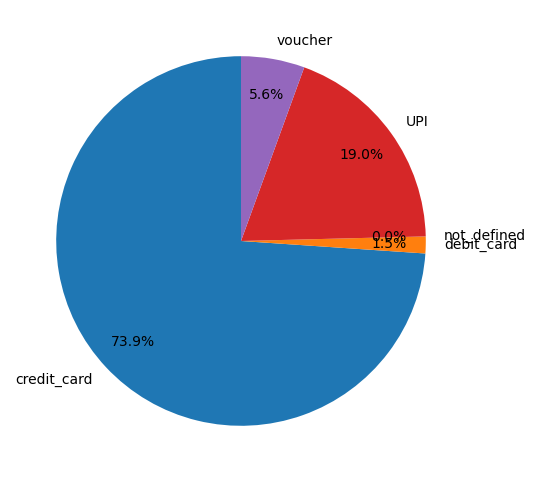

In [60]:
# Provide size of chart using figsize
plt.figure(figsize=(12,6))

# Plot pie chart
# autopct used to decide %age decimal places, pctdistance is used to give %age value distance from middle point
# startangle is used to give first record angle. for this df credit_card wull start from 90 degree angle
plt.pie(data=df, x='order_count', labels='payment_type', autopct='%1.1f%%', pctdistance=.8, startangle=90)
plt.show()